# Population Analytics

The goal of this notebook is to demonstrate how to leverage [GPW population data](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4) for model insight generation.

First:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gadm_0.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gpw_v4_2pt5_min.nc.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/sample.nc

# unzip gadm and gpw
unzip gadm_0.zip
unzip gpw_v4_2pt5_min.nc.zip

# remove zip files
rm *.zip
```

This assumes you have signed up for [GPW 4 access here](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4).

The above shell commands will download and unzip a GADM shape file for countries of the world along with GPW population data and a sample NetCDF file based on the LPJmL model's output.

## Setup

You'll need to [install CDO](https://code.mpimet.mpg.de/projects/cdo/wiki#Installation-and-Supported-Platforms) before proceeding. Make sure to follow instructions for your specific OS.

### Requirements
```
numpy==1.20.3
geopandas==0.9.0
rioxarray==0.7.1
xarray==0.18.2
cdo==1.5.5
matplotlib==3.4.2
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import geopandas as gpd
import xarray as xr

from cdo import * 
import os
os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

cdo = Cdo()
cdo.debug = False

In [3]:
model_output = xr.open_dataset('sample.nc',decode_coords="all")
model_output = model_output.rio.write_crs(4326)

# Drop time variables; for some reason clipping these is problematic...
model_output = model_output[['harvested_area','harvest','production']]

In [4]:
gpw = xr.open_dataset('gpw_v4_2pt5_min.nc',decode_coords="all")
gpw = gpw.rio.write_crs(4326)

In [5]:
shapefile = 'gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)

In [6]:
sf.head()

,GID_0,NAME_0,geometry
0,ABW,Aruba,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,"POLYGON ((68.52644 31.75435, 68.53852 31.75457..."
2,AGO,Angola,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Åland,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


Select countries of interest:

In [7]:
countries = ['Ethiopia','South Sudan','Somalia','Kenya']
countries_shp = sf[sf['NAME_0'].isin(countries)]

## Clip GPW to Ethiopia, South Sudan, Somalia, and Kenya

In [8]:
gpw_c = gpw.rio.clip(countries_shp.geometry)

In [9]:
var_name = list(gpw.data_vars.keys())[0]
print(var_name)

UN WPP-Adjusted Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes


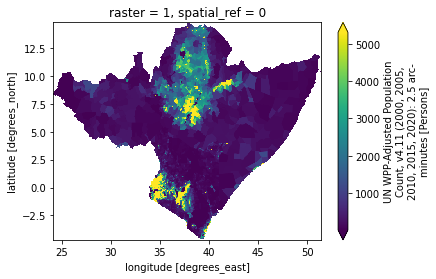

In [10]:
gpw_c\
    .isel(raster=0)\
    [var_name]\
    .plot(robust=True)

## Clip Model Output to Countries of Interest

In [11]:
model_output_c = model_output.rio.clip(countries_shp.geometry)

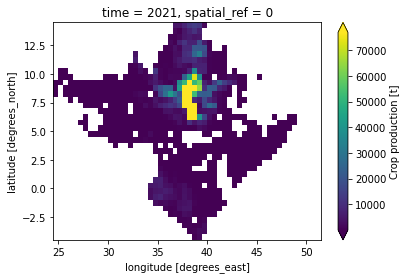

In [12]:
model_output_c\
    .isel(crop=0, time=0)\
    ['production']\
    .plot(robust=True)

## Generate temporary clipped files

In [13]:
gpw_c.to_netcdf('gpw_tmp.nc')
model_output_c.to_netcdf('sample_tmp.nc')

## Regrid GPW to match model output

In [14]:
gpw_c_regrid = cdo.remapsum("sample_tmp.nc", input="gpw_tmp.nc", options='-f nc', returnXDataset = True)

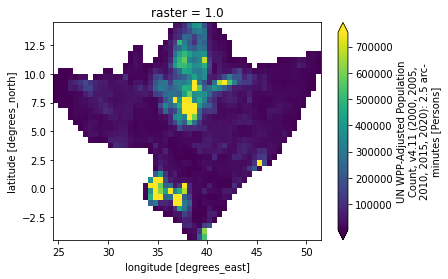

In [15]:
gpw_c_regrid\
    .isel(raster=0)\
    [var_name]\
    .plot(robust=True)

## Merge

In [16]:
merged = xr.merge([gpw_c_regrid, model_output_c])

## Create per capita variable

In [17]:
merged['production_per_cap'] = merged['production'] / merged[var_name]

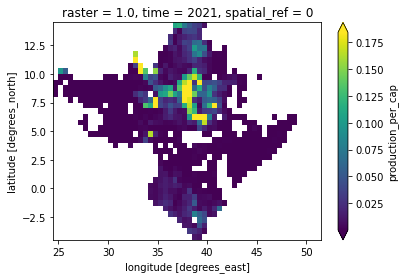

In [18]:
merged.isel(crop=0,raster=0,time=0)['production_per_cap'].plot(robust=True)